In [4]:
# Import CVX and numpy libraries
import cvxpy as cvx
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
def generate(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)

    # Construct the anchor points
    a = np.random.rand(n+1,n)
    a = origA + np.multiply(a,rangA)

    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [6]:
def generate_inside_hull(n,npoints):
    # Set the limits
    origA = np.full((n+1,n),-5.)
    rangA = np.full((n+1,n), 10.)
    origP = np.full((npoints,n),-5.)
    rangP = np.full((npoints,n), 10.)
    
    if(n == 1):
        a = np.array([-6, 6])
    elif(n == 2):
        a = np.array([[-6, 15], [-6, -15], [8, 0]])
    elif(n == 3):
        a = np.array([[-6, 15,-10], [-6, -15,-10], [8, 0, -10], [0, 0, 10]])
    # Construct the sensor points
    p = np.random.rand(npoints,n)
    p = origP + np.multiply(p,rangP)

    adjacency = np.full((npoints+n+1,npoints+n+1),-1.)

    if(n > 1):
        minConstr = 3
        maxConstr = 4
        minPointConstr = 2
        minAnchConstr = 2
    else:
        minConstr = 2
        maxConstr = 3
        minPointConstr = 1
        minAnchConstr = 1

    anchList = [i for i in range(n+1)]
    pointList = [i for i in range(npoints)]
    off = n + 1

    for i in range(npoints):
        random.shuffle(anchList)
        random.shuffle(pointList)
        # Set anchor constraints, between 1 and 3
        numAnch = random.randint(minAnchConstr,minConstr)
        for l in range(numAnch):
            adjacency[anchList[l],i+off] = np.linalg.norm(a[anchList[l]] - p[i])
            adjacency[i+off,anchList[l]] = adjacency[anchList[l],i+off]
        print(numAnch)
        # Count number of constraints already set for this point
        countConstr = 0
        for l in range(npoints+off):
            if(adjacency[l,i+off] > 0):
                countConstr = countConstr + 1
        # Set point constraints, between 0 and 3
        if(minConstr - countConstr >= 0):
            numPoint = random.randint(minConstr-countConstr,3)
            count = numPoint
            l = 0
            while(count > 0 and l < len(pointList)):
                if(pointList[l] != i):
                        countConstr = 0
                        for k in range(npoints+off):
                            if(adjacency[k,pointList[l]+off] > 0):
                                countConstr = countConstr + 1
                        if(countConstr < maxConstr):
                            adjacency[pointList[l]+off,i+off] = np.linalg.norm(p[pointList[l]] - p[i])
                            adjacency[i+off,pointList[l]+off] = adjacency[pointList[l]+off,i+off]
                            count = count - 1
                l = l + 1
    return [a, p, adjacency]

In [14]:
n = 2
npoints = 10

(a, p, adjacency) = generate(n, npoints)

# Compute the Euclidian distances to the anchor points
adjSize = len(p) + len(a)
asize = len(a)
d = []

for i in range(adjSize):
    for j in range(adjSize):
        if(j > i and adjacency[i][j] > 0 and i < asize):
            d.append((adjacency[i][j], j - asize, i, True))
        elif(j > i and adjacency[i][j] > 0):
            d.append((adjacency[i][j], i - asize, j - asize, False))

# Construct the CVX variables to minimize
x = [cvx.Variable(n) for i in range(len(p))]

print d

states = []
constr = []

cost = cvx.norm(0)
for (distance, i, j, truth) in d:
    if(truth):
        constr.append(cvx.norm(x[i] - a[j], 2) ** 2 <= distance ** 2)
    else:
        constr.append(cvx.norm(x[i] - x[j], 2) ** 2 <= distance ** 2)
        
states.append(cvx.Problem(cvx.Minimize(cost), constr))

# Add the states and solve the problem    
prob = sum(states)
prob.solve()

if(n == 1): #Solves it more or less
    print('Solution: ' + prob.status)
    for i, elem in enumerate(x):
        soln1 = elem.value
        point1 = p[i]
        print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
elif(n == 2): #Can't solve this
    print('Solution: ' + prob.status)
    for i, elem in enumerate(x):
        soln1 = elem.value.A.flatten()
        soln1 = ['%.4f' % elem for elem in soln1]
        soln1 = [float(elem) for elem in soln1]
        point1 = ['%.4f' % elem for elem in p[i]]
        point1 = [float(elem) for elem in point1]
        print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))
else:
    print('Solution: ' + prob.status)
    for i, elem in enumerate(x):
        soln1 = elem.value.A.flatten()
        soln1 = ['%.4f' % elem for elem in soln1]
        soln1 = [float(elem) for elem in soln1]
        point1 = ['%.4f' % elem for elem in p[i]]
        point1 = [float(elem) for elem in point1]
        print("Sensor " + str(i) + " is at " + str(soln1) + " and the actual value is " + str(point1))

2
3
2
2
2
3
2
2
2
3
[(6.1886872339610655, 0, 0, True), (6.25692228292856, 1, 0, True), (9.5962555328364711, 3, 0, True), (3.5117338274177072, 4, 0, True), (9.5645720282117139, 5, 0, True), (6.6562469793197847, 6, 0, True), (11.18530162691075, 7, 0, True), (3.1930730056734373, 9, 0, True), (5.8319942091170667, 0, 1, True), (5.265270274376606, 1, 1, True), (3.0255408010254077, 2, 1, True), (1.3023747782969231, 3, 1, True), (2.3903225272572635, 5, 1, True), (4.4688897299606749, 7, 1, True), (5.8851167418806449, 8, 1, True), (6.7447060168566564, 9, 1, True), (8.1672843786631137, 1, 2, True), (7.7237588711340965, 2, 2, True), (5.9615721177960443, 4, 2, True), (6.2907017605015447, 5, 2, True), (1.2519663425308454, 6, 2, True), (1.6755143067432152, 8, 2, True), (6.4451097029860653, 9, 2, True), (7.7723005148832911, 0, 1, False), (5.9555940104778555, 0, 4, False), (6.5684430384216048, 0, 9, False), (5.2898906480763896, 2, 5, False), (6.1737092942895089, 2, 8, False), (3.2124693078553501, 3, 7,

Populating the interactive namespace from numpy and matplotlib


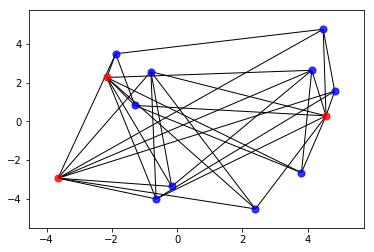

In [15]:
%pylab inline --no-import-all
if(n == 2):
    G=nx.Graph()

    for i in range(n+1):
        G.add_node(i,pos=a[i])

    for i in range(npoints):
        G.add_node(n+1+i,pos=p[i])

    pos=nx.get_node_attributes(G,'pos')

    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1)],
                           node_color='r',
                           node_size=50,
                           alpha=0.8)
    nx.draw_networkx_nodes(G,pos,
                           nodelist=[i for i in range(n+1,npoints+n+1)],
                           node_color='b',
                           node_size=50,
                           alpha=0.8)
    for i in range(npoints+n+1):
        for j in range(n+1,npoints+n+1):
            if(adjacency[j,i] > 0.):
                G.add_edge(i,j)

    nx.draw_networkx_edges(G,pos)
    plt.draw()  # pyplot draw()

In [18]:
import snap
Graph = snap.TUNGraph.New()
